In [72]:
%%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Update the dataset incase it has changed.
! cd ../input; ./update-dataset.sh >/dev/null

# Clean the input directory structure.
! rm -rf cmp23 preprocessed features
! mkdir -p {.,preprocessed}/cmp23/{fe,}male features

# Self explanatory.
! cp ../input/cmp23-handwritten-males-vs-females/Males/Males/* cmp23/male
! cp ../input/cmp23-handwritten-males-vs-females/Females/Females/* cmp23/female

# Rename all the dataset files to simple names.
! function rename { for path in "$@"; do cd $path; c=1; for file in $(/bin/ls); do /bin/mv $file $(printf "%03d" $c).jpg; let c=c+1; done; cd - >/dev/null; done; }; rename cmp23/{fe,}male

# Check the directory tree.
! tree --filelimit 100

zsh:1: no such file or directory: ./update-dataset.sh
.
├── cmp23
│   ├── female [131 entries exceeds filelimit, not opening dir]
│   └── male [232 entries exceeds filelimit, not opening dir]
├── features
├── features.py
├── helpers.py
├── malassifier2.ipynb
├── malassifier.ipynb
├── preprocessed
│   └── cmp23
│       ├── female
│       └── male
├── processing.py
├── __pycache__
│   ├── features.cpython-37.pyc
│   ├── helpers.cpython-37.pyc
│   ├── processing.cpython-37.pyc
│   └── utils.cpython-37.pyc
└── utils.py

9 directories, 10 files
CPU times: user 44.3 ms, sys: 108 ms, total: 153 ms
Wall time: 3.53 s


In [73]:
# Imports.
import os
import cv2
import math
import glob
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog

In [74]:
# Helper functions.
def cmp(gender: str, id: int):
    return f'cmp23/{gender}/{id:03}.jpg'

def is_male(path: str):
    return 'female' not in path

def gender(path: str):
    return 1 if is_male(path) else 0

def pre(image_path: str):
    return f'preprocessed/{image_path}'

def feat(feature: str):
    return f'features/{feature}.ft'

def preview(images: list):
    fig = plt.figure(figsize=(20, 20))
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        fig.add_subplot(4, 4, i + 1)
        plt.imshow(image, cmap='gray')
    plt.show()

def imread_bw(image_path: str):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.where(image > 255 / 2, 1, 0)

def prune_useless_feature_cols(features):
    zero_cols = features[0] == features[1]
    for feature_vec in features:
        zero_cols &= features[0] == feature_vec
    print(f'The following {np.sum(zero_cols)} features were removed because they are not discriminative:')
    features_to_remove = np.where(zero_cols, [x + 1 for x in range(len(zero_cols))], -1)
    print(features_to_remove[features_to_remove != -1])
    return features[:, ~zero_cols]

def norm(features):
    features = prune_useless_feature_cols(np.array(features))
    features = normalize(features, axis=0)
    # Ceil all the fractions (representing male class) back to one.
    features[features[:, -1] > 0, -1] = 1
    return features

def ojalat_lbp(image, n_points=16, radius=2):
    lbp = local_binary_pattern(image, n_points, radius, method='nri_uniform')
    # [n * (n - 1) + 2] for uniform bp and [1] more bin for non uniform bp.
    n_bins = n_points * (n_points - 1) + 2 + 1
    hist = np.histogram(lbp.ravel(), bins=np.arange(n_bins + 1), normed=True)[0]
    return hist

def freeman_cc_hists(image):
    # Get the image contours.
    contours = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
    # A direction to index map.
    DIR8S = {(1, 0): 0, (1, 1): 1, (0, 1): 2, (-1, 1): 3, (-1, 0): 4, (-1, -1): 5, (0, -1): 6, (1, -1): 7,}
    # Create an 8-bin histogram for the chain codes.
    chain_code_hist = np.zeros(8)
    # Create a 8x8 matrix for the chain code pairs.
    chain_code_pairs_hist = np.zeros((8, 8))
    for contour in contours:
        # Skip these contours to avoid errors. They carry very few information anyway.
        if len(contour) < 2: continue
        previous_point = contour[1]
        previous_direction = DIR8S[tuple((previous_point - contour[0])[0])]
        # Don't forget to account for previous direction.
        chain_code_hist[previous_direction] += 1
        for point in contour[2:]:
            direction = DIR8S[tuple((point - previous_point)[0])]
            chain_code_hist[direction] += 1
            chain_code_pairs_hist[previous_direction, direction] += 1
            previous_point = point
            previous_direction = direction
    # Normalize the histograms.
    chain_code_hist /= np.sum(chain_code_hist)
    chain_code_pairs_hist = chain_code_pairs_hist.ravel() / np.sum(chain_code_pairs_hist)
    return np.append(chain_code_hist, chain_code_pairs_hist)

def slopes_and_curves(image):
    # Get the image contours.
    contours = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)[0]
    def bound_angle(minimum: float, maximum: float):
        def _bounder(angle: float):
            if angle < minimum:
                return angle + 180
            if angle >= maximum:
                return angle - 180
            return angle
        return _bounder
    slopes = [] # [-90, 90)
    curves = [] # [0, 190)
    for contour in contours:
        # Skip these contours to avoid errors. They carry very few information anyway.
        if len(contour) < 2: continue
        previous_point = contour[1]
        previous_slope = math.degrees(math.atan2(*(previous_point - contour[0])[0]))
        # Don't forget to account for that previous slope.
        slopes.append(previous_slope)
        for point in contour:
            slope = math.degrees(math.atan2(*(point - previous_point)[0]))
            slopes.append(slope)
            curves.append(slope - previous_slope)
            previous_point = point
            previous_slope = slope
    slopes_hist = np.histogram([*map(bound_angle(-90, 90), slopes)],
                               bins=np.arange(-90, 90 + 1, 180 / 8))[0]
    curves_hist = np.histogram([*map(bound_angle(0, 180), curves)],
                               bins=np.arange(0, 180 + 1, 180 / 8))[0]
    # Normalize the histograms.
    slopes_hist = slopes_hist / np.sum(slopes_hist)
    curves_hist = curves_hist / np.sum(curves_hist)
    return np.append(slopes_hist, curves_hist)

In [76]:
# Constants.
ALL_IMAGES = glob.glob(cmp('*', 1).replace('001', '*'))

TST_IMAGES = [
    cmp('female', 9),
    cmp('male', 67),
    cmp('male', 89),
    cmp('female', 3),
    cmp('male', 12),
    cmp('female', 4),
] # Some images' paths used oberservation.

PREPROCESSING_GAUSSIAN_BLUR_KERNEL_SIZE = (9, 9)
PREPROCESSING_DILATION_ITERATIONS = 8
PREPROCESSING_DILATION_SIZE = (15, 20) # We need more dilation into the vertical axis.
PREPROCESSING_THRESH_BLOCK_SIZE = 101 # 101 is quick enough, yet robust.
PREPROCESSING_THRESH_C = 30 # Note that we need a big C subtractor when we use a big block size.
X_CUT_PERCENT = 0.1 # Don't cut too much since some people write to edge of the paper.
Y_CUT_PERCENT = 0.5 # 0.5% on both sides is enough.

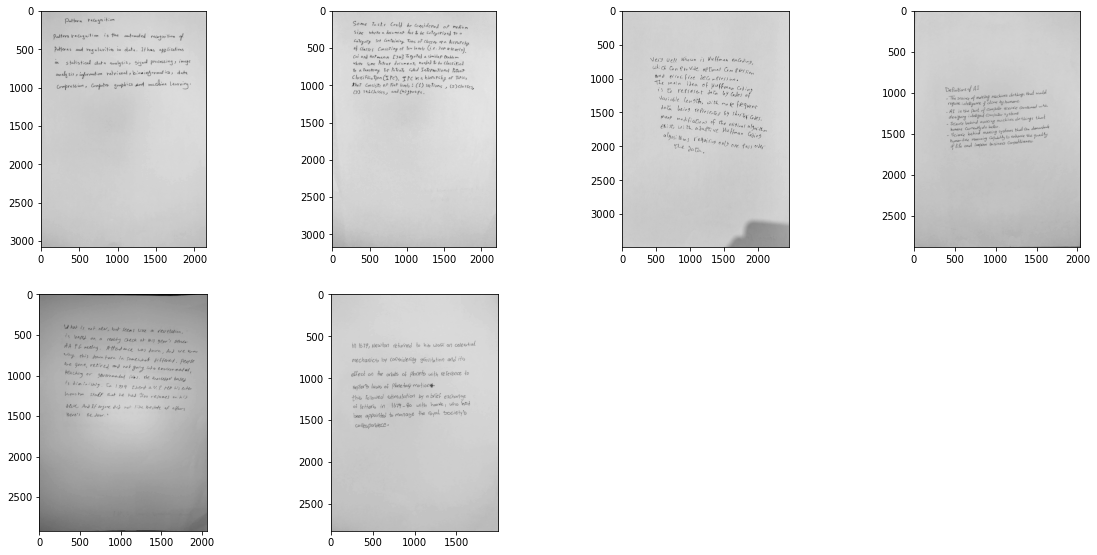

In [77]:
# Preview the test images before preprocessing them.
preview(TST_IMAGES)

In [78]:
%%time
# Preprocess the images and write them to the disk.
for image_path in ALL_IMAGES:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Cut some percentage of the images' edges. They are usually noisy.
    height, width = image.shape
    if X_CUT_PERCENT:
        start_x, end_x = int(width / (100/X_CUT_PERCENT)), width - int(width / (100/X_CUT_PERCENT))
        image = image[:, start_x:end_x]
    if Y_CUT_PERCENT:
        start_y, end_y = int(height / (100/Y_CUT_PERCENT)), height - int(height / (100/Y_CUT_PERCENT))
        image = image[start_y:end_y, :]
    # Blur the image to decrease sharpness. Good for thresholding.
    img = cv2.GaussianBlur(image, PREPROCESSING_GAUSSIAN_BLUR_KERNEL_SIZE, 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
                                PREPROCESSING_THRESH_BLOCK_SIZE, PREPROCESSING_THRESH_C)
    # Dilate the image to create a contour out of the handwritten text.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, PREPROCESSING_DILATION_SIZE)
    img = cv2.dilate(img, kernel, iterations=PREPROCESSING_DILATION_ITERATIONS)
    contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    # Get the biggest contour that contains the text.
    biggest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    # Get the original image in black and white. Note that this version is not blured.
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
                                  PREPROCESSING_THRESH_BLOCK_SIZE, PREPROCESSING_THRESH_C)
    image = cv2.threshold(image, 255 / 2, 255, cv2.THRESH_BINARY)[1]
    # Crop only the text part.
    x, y, w, h = cv2.boundingRect(biggest_contour)
    image = image[y:y + h, x:x + w]
    # Write the preprocessed image to the disk.
    cv2.imwrite(pre(image_path), image)

CPU times: user 3min 2s, sys: 2.23 s, total: 3min 5s
Wall time: 2min 46s


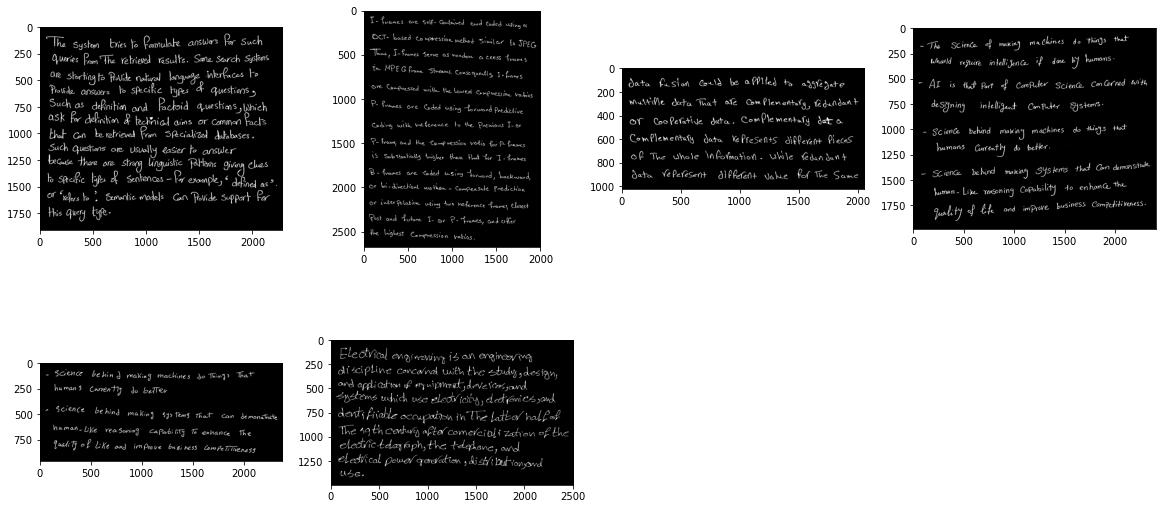

In [7]:
# Preview the test images after preprocessing.
preview(map(pre, TST_IMAGES))

In [38]:
def svm_test(features, times=100, test_size=0.2, **kwargs):
    tr_ac, ts_ac, mal, fem = 0, 0, 0, 0
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(features[:,:-1], features[:,-1], test_size=test_size)
        clf = svm.SVC(**kwargs)
        clf.fit(X_train, y_train)
        tr_ac += clf.score(X_train, y_train)
        ts_ac += clf.score(X_test, y_test)
        mal += np.sum(clf.predict(features[:,:-1]) == 1) / len(features[:,:-1])
        fem += np.sum(clf.predict(features[:,:-1]) == 0) / len(features[:,:-1])
    ret = ts_ac * 100 / times, tr_ac * 100 / times, mal * 100 / times, fem * 100 / times
    print('male_predict% = {}\nfemale_predict% = {}'.format(*ret[2:]))
    return ret[:2]

def ann_test(features, times=100, test_size=0.2, **kwargs):
    tr_ac, ts_ac, mal, fem = 0, 0, 0, 0
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(features[:, :-1], features[:, -1], test_size=test_size)
        clf = MLPClassifier(solver='lbfgs',
                            hidden_layer_sizes=(5, 2),
                            activation="identity",
                            max_iter=10000,
                            **kwargs)
        clf.fit(X_train, y_train)
        tr_ac += clf.score(X_train, y_train)
        ts_ac += clf.score(X_test, y_test)
        mal += np.sum(clf.predict(features[:, :-1]) == 1) / len(features[:, :-1])
        fem += np.sum(clf.predict(features[:, :-1]) == 0) / len(features[:, :-1])
    ret = ts_ac * 100 / times, tr_ac * 100 / times, mal * 100 / times, fem * 100 / times 
    print('male_predict = {} %\nfemale_predict = {} %'.format(*ret[2:]))
    return ret[:2]

def plt_test(features):
    males = features[features[:,-1] == 1]
    females = features[features[:,-1] == 0]
    for f1 in range(0, len(males[0,:-1])):
        print(f1)
        plt.plot(males[:, f1], males[:, -1], 'bo')
        plt.plot(females[:, f1], females[:, -1], 'rx')
        plt.show()

In [71]:
%%time
# GLCM features.
cmp_features = []

angles=[0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
distances = [1]
props = ['contrast', 'homogeneity', 'energy', 'correlation', 'entropy']

for image_path in map(pre, ALL_IMAGES):
    image = imread_bw(image_path)
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=2, symmetric=False, normed=True)
    features = []
    for prop in props:
        if prop == 'entropy':
            # Since graycoprops doesn't support calculating entropy.
            features.append([-np.sum(glcm[:, :, d, a] * np.log(glcm[:, :, d, a])) for d in range(len(distances)) for a in range(len(angles))])
        else:
            features.append(graycoprops(glcm, prop).ravel())
    features.append(gender(image_path))
    cmp_features.append(np.hstack(features))

# Normalize the features and save them.
np.savetxt(feat('glcm'), norm(cmp_features))

preprocessed/cmp23/male/219.jpg
preprocessed/cmp23/male/201.jpg
preprocessed/cmp23/male/59.jpg


TypeError: '>' not supported between instances of 'NoneType' and 'float'

In [69]:
features = np.loadtxt(feat('glcm'))
al_imgs = sorted(glob.glob(cmp('*', '*')))
labels = np.array([[gender(image_path)] for image_path in al_imgs])
features = np.append(features, labels, axis=1)
print(features.shape)
svm_test(features, C=10, kernel='rbf', times=100)

(363, 21)
male_predict% = 100.0
female_predict% = 0.0


(64.35616438356165, 63.799999999999955)

In [53]:
%%time
# LBP features.
cmp_features = []

for image_path in map(pre, ALL_IMAGES):
    image = imread_bw(image_path)
    cmp_features.append(np.append(ojalat_lbp(image), gender(image_path)))

# Normalize the features and save them.
np.savetxt(feat('lbp'), norm(cmp_features))

/home/omar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


The following 112 features were removed because they are not discriminative:
[  3   5   7   9  11  13  15  17  20  21  24  25  28  29  32  33  37  41
  45  49  50  53  54  57  58  61  62  65  67  69  71  73  75  77  79  81
  84  85  88  89  92  93  96  97 101 105 109 113 114 117 118 121 122 125
 126 129 131 133 135 137 139 141 143 145 148 149 152 153 156 157 160 161
 165 169 173 177 178 181 182 185 186 189 190 193 195 197 199 201 203 205
 207 209 212 213 216 217 220 221 224 225 226 228 229 230 232 233 234 236
 237 238 240 241]
CPU times: user 4min 20s, sys: 1.06 s, total: 4min 21s
Wall time: 4min 21s


In [59]:
features = np.loadtxt(feat('lbp'))
svm_test(features, C=10, kernel='rbf', times=100)

male_predict% = 64.57851239669421
female_predict% = 35.42148760330579


(75.80821917808224, 97.5724137931033)

In [115]:
%%time
# HoG features.
cmp_features = []

resize_w, resize_h = (0, 0)
for image_path in map(pre, ALL_IMAGES):
    image = imread_bw(image_path)
    resize_h += image.shape[0]
    resize_w += image.shape[1]

# Get the average width and height.
resize_w, resize_h = resize_w / len(ALL_IMAGES), resize_h / len(ALL_IMAGES)
# Upscale the resize parameters so not to lose any resolution.
resize_factor = int(resize_w * 1.15), int(resize_h * 1.15)

for image_path in map(pre, ALL_IMAGES):
    image = imread_bw(image_path).astype('float')
    image = cv2.resize(image, resize_factor)
    features = hog(image, orientations=9, pixels_per_cell=(16, 16),
                   cells_per_block=(1, 1), transform_sqrt=False)
    features = np.append(features.ravel(), gender(image_path))
    cmp_features.append(features)

cmp_features = np.array(cmp_features)
cmp_features = np.append(PCA().fit_transform(cmp_features[:,:-1]), cmp_features[:,[-1]], axis=1)
# Normalize the features and save them.
np.savetxt(feat('hog'), norm(cmp_features))

The following 0 features were removed because they are not discriminative:
[]
CPU times: user 7min 38s, sys: 31.1 s, total: 8min 9s
Wall time: 7min 26s


In [116]:
features = np.loadtxt(feat('hog'))
svm_test(features, C=10, kernel='rbf', times=100)

male_predict% = 71.09641873278241
female_predict% = 28.903581267217625


(64.27397260273976, 100.0)

In [117]:
%%time
# Chain Code features.
cmp_features = []

for image_path in map(pre, ALL_IMAGES):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cmp_features.append(np.append(freeman_cc_hists(image), gender(image_path)))

# Normalize the features and save them.
np.savetxt(feat('chain_codes_and_pairs'), norm(cmp_features))

The following 12 features were removed because they are not discriminative:
[11 12 21 29 30 39 47 48 49 57 58 67]
CPU times: user 14min 16s, sys: 1.65 s, total: 14min 18s
Wall time: 14min 12s


In [207]:
features = np.loadtxt(feat('chain_codes_and_pairs'))
svm_test(features, C=10, kernel='rbf', times=100)

male_predict% = 64.69696969696972
female_predict% = 35.303030303030326


(69.36986301369865, 94.91379310344833)

In [200]:
%%time
# Distribution of segment slopes and distribution of curvature features.
cmp_features = []

for image_path in map(pre, ALL_IMAGES):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cmp_features.append(np.append(slopes_and_curves(image), gender(image_path)))

# Normalize the features and save them.
np.savetxt(feat('slopes_and_curves'), norm(cmp_features))

The following 0 features were removed because they are not discriminative:
[]
CPU times: user 2min 27s, sys: 2.04 s, total: 2min 29s
Wall time: 2min 22s


In [203]:
features = np.loadtxt(feat('slopes_and_curves'))
svm_test(features, C=10, kernel='rbf', times=100)

male_predict% = 65.05647382920097
female_predict% = 34.94352617079888


(67.33013698630118, 94.41931034482656)

In [236]:
all_features = [
    np.loadtxt(feat('chain_codes_and_pairs')),
    np.loadtxt(feat('slopes_and_curves')),
    np.loadtxt(feat('lbp')),
    np.loadtxt(feat('glcm')),
    #np.loadtxt(feat('hog')),
]

features = all_features[0]
for feature in all_features[1:]:
    features = np.append(feature[:, :-1], features, axis=1)

svm_test(features, C=10, kernel='rbf', times=100)

male_predict% = 65.85123966942149
female_predict% = 34.1487603305785


(75.38356164383563, 96.47931034482762)

In [39]:
import collections
import cv2
import sys
import time
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.measure
from sklearn import svm
from skimage.filters import gabor
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern


def get_contour_pixels(bw_image):
    contours = cv2.findContours(bw_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
    # contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[0:]
    return contours


def get_hinge_features(bw_image):
    
    N_ANGLE_BINS = 40
    BIN_SIZE = 360 // N_ANGLE_BINS
    LEG_LENGTH = 25
    contours = get_contour_pixels(bw_image)

    hist = np.zeros((N_ANGLE_BINS, N_ANGLE_BINS))

    # print([len(cnt) for cnt in contours])
    for cnt in contours:
        n_pixels = len(cnt)
        if n_pixels <= LEG_LENGTH:
            continue

        points = np.array([point[0] for point in cnt])
        xs, ys = points[:, 0], points[:, 1]
        point_1s = np.array([cnt[(i + LEG_LENGTH) % n_pixels][0]
                             for i in range(n_pixels)])
        point_2s = np.array([cnt[(i - LEG_LENGTH) % n_pixels][0]
                             for i in range(n_pixels)])
        x1s, y1s = point_1s[:, 0], point_1s[:, 1]
        x2s, y2s = point_2s[:, 0], point_2s[:, 1]

        phi_1s = np.degrees(np.arctan2(y1s - ys, x1s - xs) + np.pi)
        phi_2s = np.degrees(np.arctan2(y2s - ys, x2s - xs) + np.pi)

        indices = np.where(phi_2s > phi_1s)[0]

        for i in indices:
            phi1 = int(phi_1s[i] // BIN_SIZE) % N_ANGLE_BINS
            phi2 = int(phi_2s[i] // BIN_SIZE) % N_ANGLE_BINS
            hist[phi1, phi2] += 1

    normalised_hist = hist / np.sum(hist)
    feature_vector = normalised_hist[np.triu_indices_from(normalised_hist, k=1)]

    return feature_vector


def get_cold_features(bw_image, approx_poly_factor=0.01):
    N_RHO_BINS = 7
    N_ANGLE_BINS = 12
    N_BINS = N_RHO_BINS * N_ANGLE_BINS
    BIN_SIZE = 360 // N_ANGLE_BINS
    R_INNER = 5.0
    R_OUTER = 35.0
    K_S = np.arange(3, 8)
    contours = get_contour_pixels(bw_image)

    rho_bins_edges = np.log10(np.linspace(R_INNER, R_OUTER, N_RHO_BINS))
    feature_vectors = np.zeros((len(K_S), N_BINS))

    # print([len(cnt) for cnt in contours])
    for j, k in enumerate(K_S):
        hist = np.zeros((N_RHO_BINS, N_ANGLE_BINS))
        for cnt in contours:
            epsilon = approx_poly_factor * cv2.arcLength(cnt, True)
            cnt = cv2.approxPolyDP(cnt, epsilon, True)
            n_pixels = len(cnt)

            point_1s = np.array([point[0] for point in cnt])
            x1s, y1s = point_1s[:, 0], point_1s[:, 1]
            point_2s = np.array([cnt[(i + k) % n_pixels][0]
                                 for i in range(n_pixels)])
            x2s, y2s = point_2s[:, 0], point_2s[:, 1]

            thetas = np.degrees(np.arctan2(y2s - y1s, x2s - x1s) + np.pi)
            rhos = np.sqrt((y2s - y1s) * 2 + (x2s - x1s) * 2)
            rhos_log_space = np.log10(rhos)

            quantized_rhos = np.zeros(rhos.shape, dtype=int)
            for i in range(N_RHO_BINS):
                quantized_rhos += (rhos_log_space < rho_bins_edges[i])

            for i, r_bin in enumerate(quantized_rhos):
                theta_bin = int(thetas[i] // BIN_SIZE) % N_ANGLE_BINS
                hist[r_bin - 1, theta_bin] += 1

        normalised_hist = hist / hist.sum()
        feature_vectors[j] = normalised_hist.flatten()

    return feature_vectors.flatten()


In [27]:
%%time
cmp_features = []
for image_path in map(pre, ALL_IMAGES):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cmp_features.append(np.append(get_hinge_features(image), gender(image_path)))

np.savetxt(feat('hinge'), norm(cmp_features))

The following 0 features were removed because they are not discriminative:
[]
CPU times: user 3min 48s, sys: 1.63 s, total: 3min 49s
Wall time: 3min 43s


In [50]:
%%time
features = np.loadtxt(feat('hinge'))
print(features.shape)
svm_test(features, C=10, kernel='rbf', times=100)

(363, 781)
male_predict% = 64.48209366391183
female_predict% = 35.51790633608816
CPU times: user 12.6 s, sys: 16.2 ms, total: 12.6 s
Wall time: 12.6 s


(79.24657534246577, 100.0)

In [46]:
%%time
cmp_features = []
for image_path in map(pre, ALL_IMAGES):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cmp_features.append(np.append(get_cold_features(image), gender(image_path)))

np.savetxt(feat('cold'), norm(cmp_features))

/home/omar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt
/home/omar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log10


The following 207 features were removed because they are not discriminative:
[  1   2   3   4   5   6   8  11  12  13  14  15  16  17  23  24  25  26
  27  28  29  35  36  37  38  39  40  41  47  48  49  50  51  52  60  61
  62  63  64  72  85  86  87  88  89  90  93  94  95  96  97  98  99 100
 101 105 106 107 108 109 110 111 112 113 119 120 121 122 123 124 125 131
 132 133 134 135 136 144 145 146 147 148 156 169 170 171 172 173 174 179
 180 181 182 183 184 185 189 191 192 193 194 195 196 197 203 204 205 206
 207 208 209 215 216 217 218 219 220 228 229 230 231 232 240 253 254 255
 256 257 258 260 261 262 263 264 265 266 267 268 269 272 273 274 275 276
 277 278 279 280 281 287 288 289 290 291 292 293 299 300 301 302 303 304
 312 313 314 315 316 324 337 338 339 340 341 344 347 348 349 350 351 352
 353 359 360 361 362 363 364 365 371 372 373 374 375 376 377 383 384 385
 386 387 388 396 397 398 399 400 408]
CPU times: user 39min 53s, sys: 1.64 s, total: 39min 54s
Wall time: 39min 50s


In [47]:
features = np.loadtxt(feat('cold'))
svm_test(features, C=10, kernel='rbf', times=100)

male_predict% = 73.99724517906331
female_predict% = 26.002754820936644


(67.21917808219182, 89.7724137931035)